In [1]:

from tenpy.tools.misc import to_array
from tenpy.tools import hdf5_io
import tenpy
import h5py
import sys, numpy as np
import matplotlib.pyplot as pl
from matplotlib import cm
from matplotlib import ticker
from matplotlib.colors import to_rgb

def load_data_h5(fname):
    with h5py.File(fname, 'r') as f:
        data = hdf5_io.load_from_hdf5(f)
        return data

cblue = '#0f3f67ff'
cred = '#d62d20'
cdarkred ='#a41212'
cgrey = '#c0c5ce'
tenpy.show_config()

print("Python:", sys.executable)
print("NumPy:", np.__version__)
np.__config__.show()

tenpy 1.0.6 (compiled without HAVE_MKL),
git revision a2c3e8f2dfd1aed32ee03d5722eaf15b15216674 using
python 3.12.3 (main, Aug 14 2025, 17:47:21) [GCC 13.3.0]
numpy 2.3.4, scipy 1.16.2
Python: /home/t30/all/ge54yin/Documents/MasterThesisFQHinTMDs/MPS_stuff/MPScalculations/.venv/bin/python
NumPy: 2.3.4
Build Dependencies:
  blas:
    detection method: pkgconfig
    found: true
    include directory: /opt/_internal/cpython-3.12.12/lib/python3.12/site-packages/scipy_openblas64/include
    lib directory: /opt/_internal/cpython-3.12.12/lib/python3.12/site-packages/scipy_openblas64/lib
    name: scipy-openblas
    openblas configuration: OpenBLAS 0.3.30  USE64BITINT DYNAMIC_ARCH NO_AFFINITY
      Haswell MAX_THREADS=64
    pc file directory: /project/.openblas
    version: 0.3.30
  lapack:
    detection method: pkgconfig
    found: true
    include directory: /opt/_internal/cpython-3.12.12/lib/python3.12/site-packages/scipy_openblas64/include
    lib directory: /opt/_internal/cpython-3.12.12/

In [2]:
def plot_ent_spect_color(ax, ent_spect, Ly, PRINT=False, permute=[], counting=[], Q=0):
    """
    Plot entanglement spectrum for a single charge sector Q as colored scatter points vs momentum.

    Parameters
    - ax : matplotlib.axes.Axes
        Axes object to draw the scatter plot on.
    - ent_spect : list
        List of tuples (q, s) returned by TenPy's entanglement_spectrum(by_charge=True).
        q is an array-like [charge, momentum], s is a 1D array of entanglement eigenvalues.
    - Ly : int
        Number of momentum sectors (used to set x-ticks and momentum grid).
    - PRINT : bool, optional
        If True, prints the eigenvalue arrays for the plotted sector(s).
    - permute : sequence of int, optional
        Permutation of momentum indices; length should be Ly. If length != Ly, defaults to np.arange(Ly).
    - counting : sequence of int, optional
        Per-momentum integer counts; the first `counting[k]` points at momentum k are drawn in a highlight color.
        If length != Ly, defaults to zeros.
    - Q : int, optional
        Charge sector to plot (only entries with q[0] == Q are drawn).

    Behavior / Notes
    - Uses global colormap cm.RdBu and the color constants defined in the notebook (e.g. cgrey).
    - Sets x-ticks to k = 0..Ly-1 scaled by 2*pi/Ly and labels them with `permute`.
    - Adds minor y-ticks and applies inwards tick styling.
    - Calls pl.show() at the end.
    - Returns None (draws on the provided Axes).
    """
    if len(permute) != Ly:
        permute = np.arange(Ly)
    
    if len(counting) != Ly:
        counting = np.zeros(Ly, dtype=int)
    for q,s in ent_spect:
        qo = np.array(q)
        q = [qo[0],qo[1]]
        # q[0] is charge, q[1] is momentum
        klist = np.arange(0, Ly) * 2 * np.pi / Ly
        if q[0] == Q:  # take selected charge excitations
            kVal = permute[q[1]]
            crls = [cgrey for nn in range(len(s))]
            for ii in range(counting[kVal]):
                crls[ii] = cm.RdBu(0.15)
            ax.scatter(np.zeros(s.shape) + klist[kVal], s, marker='o',
                       linewidths=0.3, edgecolors='black', c=crls)
            if PRINT:
                print(s)
        
    # Add minor ticks - Split major tick interval in two bins
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
    ax.tick_params(which='both', axis="both", direction='in')    

    ax.set_xticks(np.arange(Ly) * 2 * np.pi / Ly)
    labels = permute
    ax.set_xticklabels(labels)
    ax.set_xlabel(r"momentum $L_y \cdot k_y/2\pi$")
    ax.set_ylabel(r"eigenvalues $ \epsilon_\alpha $")

    pl.show()



def plot_ent_spect_allQ(ax, ent_spect, Ly, PRINT=False, permute=[], counting=[], legend=False):
    """
    Plot entanglement spectrum for multiple charge sectors on the same axes, color-coded by charge Q.

    Parameters
    - ax : matplotlib.axes.Axes
        Axes object to draw the scatter plots on.
    - ent_spect : list
        List of tuples (q, s) as from TenPy's entanglement_spectrum(by_charge=True).
    - Ly : int
        Number of momentum sectors (used to set x-ticks and momentum grid).
    - PRINT : bool, optional
        If True, prints the eigenvalue arrays as they are plotted.
    - permute : sequence of int, optional
        Permutation of momentum indices; length should be Ly. If length != Ly, defaults to np.arange(Ly).
    - counting : sequence of int, optional
        Per-momentum integer counts (currently unused for special styling in this routine).
    - legend : bool, optional
        If True, displays a legend mapping colors to charge Q.

    Behavior / Notes
    - Loops over Q in [-Qmax, ..., Qmax] (Qmax is hard-coded as 4 here) and plots points offset by 0.1*Q
      along x so different charges at the same momentum do not overlap exactly.
    - Uses cm.coolwarm for the Q color mapping.
    - Sets x-ticks to k = 0..Ly-1 scaled by 2*pi/Ly and labels them with `permute`.
    - Adds minor y-ticks and applies inwards tick styling.
    - Calls pl.show() at the end.
    - Returns None (draws on the provided Axes).

    Example
    - Call with the entanglement spectrum list produced by TenPy:
        plot_ent_spect_allQ(ax, ent_spect, Ly, legend=True)
    """
    if len(permute) != Ly:
        permute = np.arange(Ly)
    
    if len(counting) != Ly:
        counting = np.zeros(Ly, dtype=int)
    Qlist = []
    for q,s in ent_spect:
        qo = np.array(q)
        q = [qo[0],qo[1]]
        # q[0] is charge, q[1] is momentum
        klist = np.arange(0, Ly) * 2 * np.pi / Ly
        Qmax = 4
        crls_list = np.linspace(0, 1, 2*Qmax+1)
        for Q in range(-Qmax, Qmax+1):
            if q[0] == Q:
                kVal = permute[q[1]]
                if Q not in Qlist:
                    ax.scatter(np.zeros(s.shape) + klist[kVal] + 0.1*Q, s, marker='o',
                               linewidths=0.3, edgecolors='black',
                               color=cm.coolwarm(crls_list[Q+Qmax]), label=f'Q={Q:d}')
                else:
                    ax.scatter(np.zeros(s.shape) + klist[kVal] + 0.1*Q, s, marker='o',
                               linewidths=0.3, edgecolors='black',
                               color=cm.coolwarm(crls_list[Q+Qmax]))
                Qlist.append(Q)
                if PRINT:
                    print(s)
        
    # Add minor ticks - Split major tick interval in two bins
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
    ax.tick_params(which='both', axis="both", direction='in')    
    if legend:
        ax.legend(loc='best')

    ax.set_xticks(np.arange(Ly) * 2 * np.pi / Ly)
    labels = permute
    ax.set_xticklabels(labels)
    ax.set_xlabel(r"momentum $L_y \cdot k_y/2\pi$")
    ax.set_ylabel(r"eigenvalues $ \epsilon_\alpha $")

    pl.show()


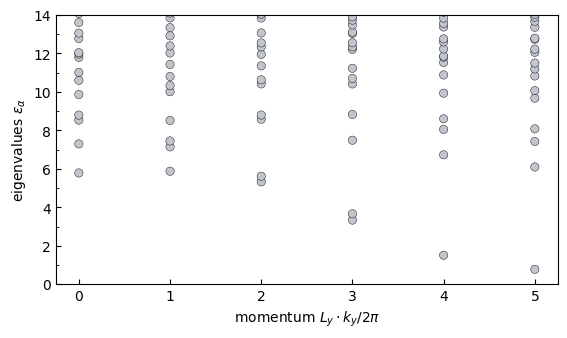

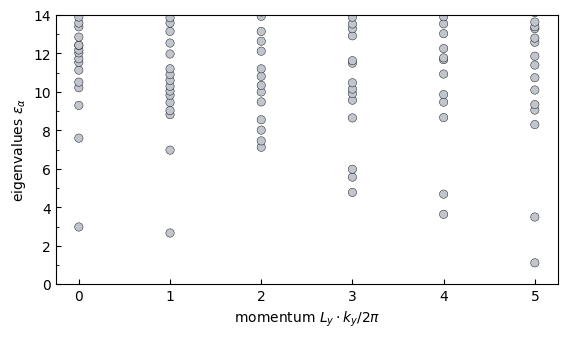

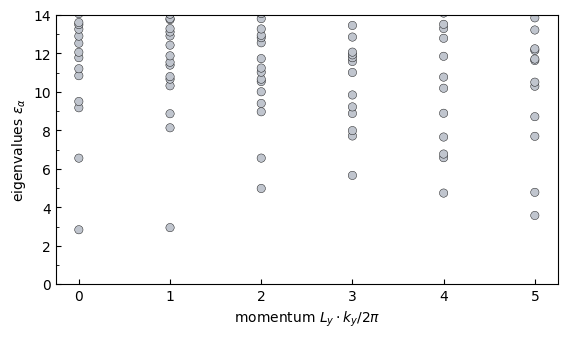

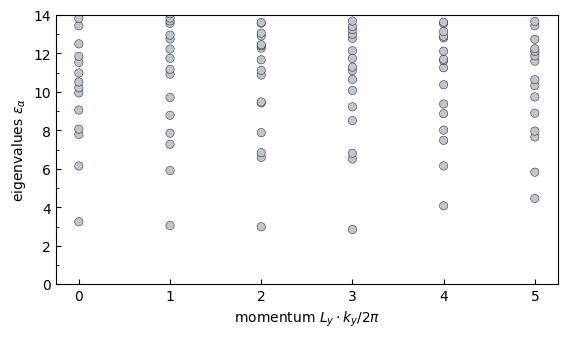

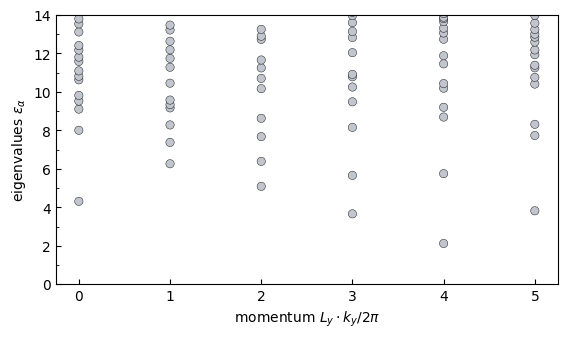

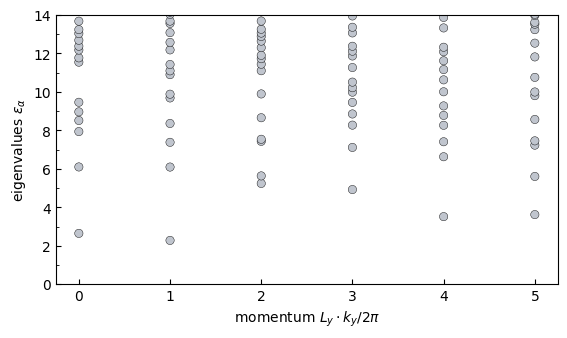

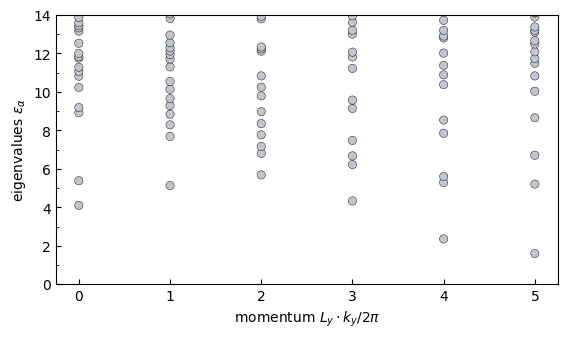

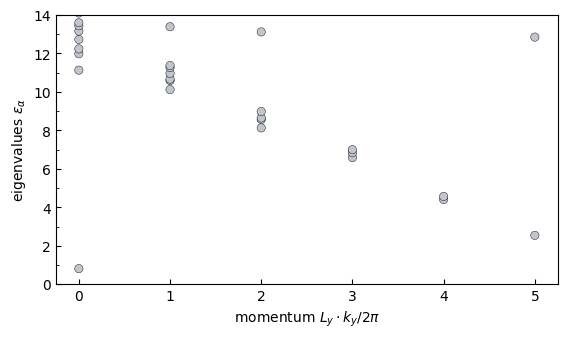

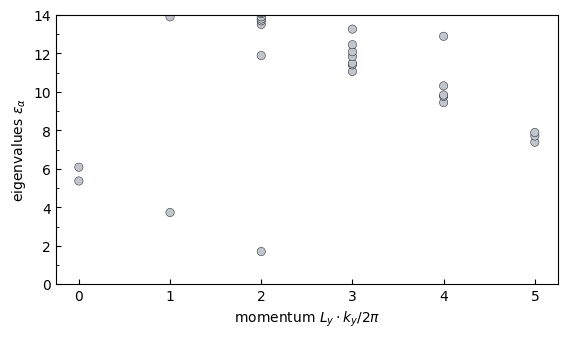

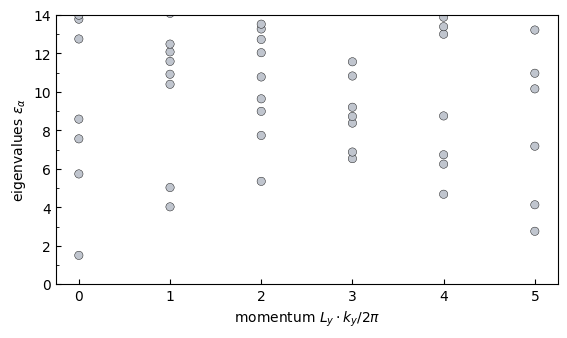

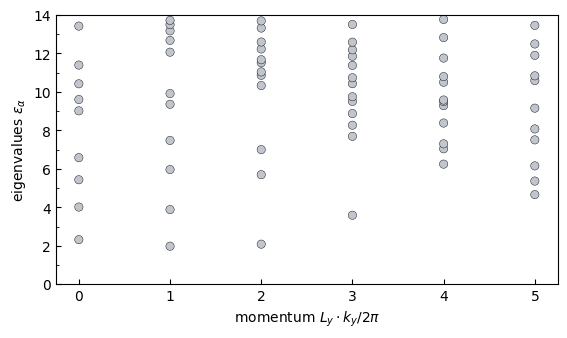

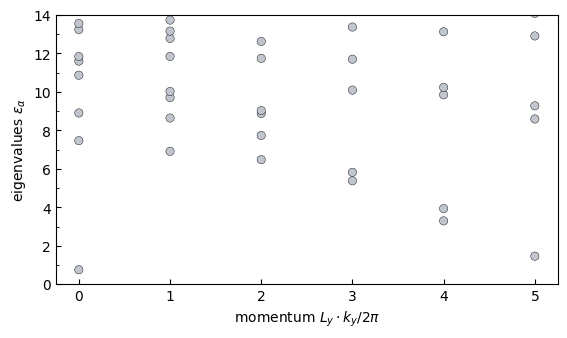

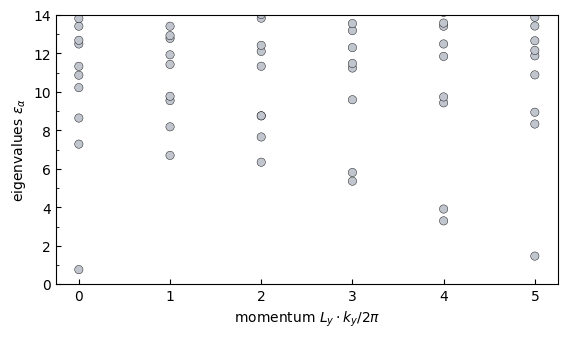

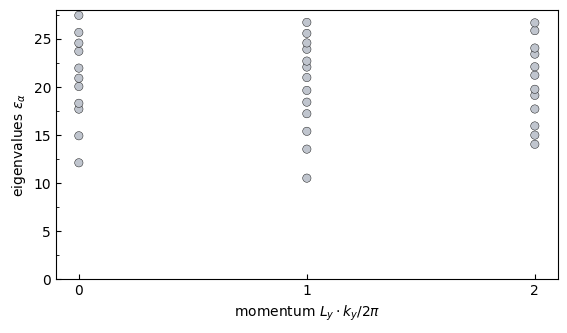

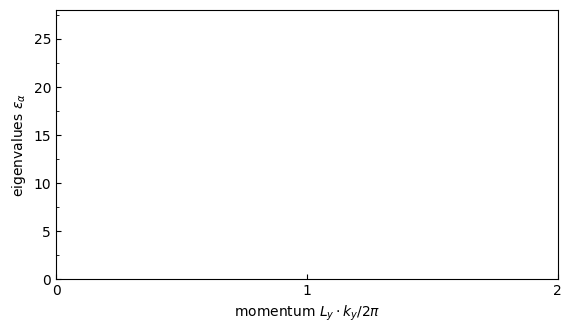

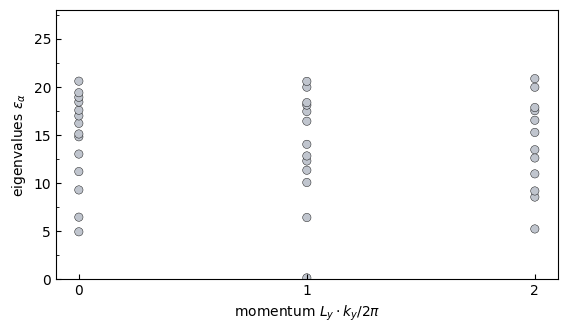

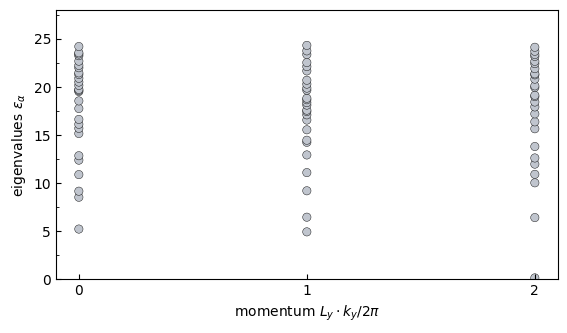

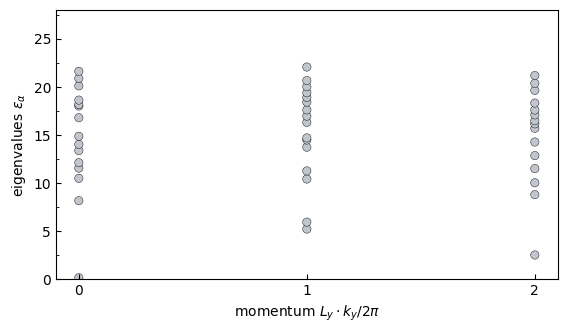

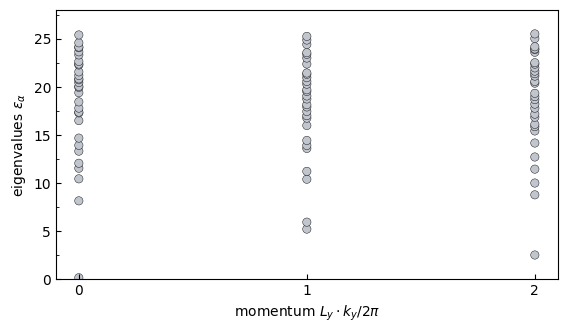

In [15]:
loc = '/home/t30/all/ge54yin/Documents/MasterThesisFQHinTMDs/MPS_stuff/MPScalculations/'
#modify as needed
V = 0.50
K = 1
Ly1 = 6
Ly2 = 3
fname11_1 = f'extract_xk_Hofst_chi128_Lx2_Ly{Ly1:d}_V{V:.2f}_t-1.00_D0.00_tp-0.25_N6_K3.h5'
fname21_1 = f'extract_xk_Hofst_chi128_Lx2_Ly{Ly1:d}_V{V:.2f}_t-1.00_D0.00_tp-0.25_N4_K3.h5'
fname31_1 = f'extract_xk_Hofst_chi128_Lx2_Ly{Ly1:d}_V{V:.2f}_t-1.00_D0.00_tp-0.25_N2_K3.h5'

fname12_1 = f'extract_xk_Hofst_chi256_Lx2_Ly{Ly1:d}_V{V:.2f}_t-1.00_D0.00_tp-0.25_N6_K3.h5'
fname22_1 = f'extract_xk_Hofst_chi256_Lx2_Ly{Ly1:d}_V{V:.2f}_t-1.00_D0.00_tp-0.25_N4_K3.h5'
fname32_1 = f'extract_xk_Hofst_chi256_Lx2_Ly{Ly1:d}_V{V:.2f}_t-1.00_D0.00_tp-0.25_N2_K3.h5'

fname11_2 = f'extract_xk_Hofst_chi128_Lx2_Ly{Ly2:d}_V{V:.2f}_t-1.00_D0.00_tp-0.25_N3_K2.h5'
fname21_2 = f'extract_xk_Hofst_chi128_Lx2_Ly{Ly2:d}_V{V:.2f}_t-1.00_D0.00_tp-0.25_N2_K2.h5'
fname31_2 = f'extract_xk_Hofst_chi128_Lx2_Ly{Ly2:d}_V{V:.2f}_t-1.00_D0.00_tp-0.25_N1_K2.h5'

fname12_2 = f'extract_xk_Hofst_chi256_Lx2_Ly{Ly2:d}_V{V:.2f}_t-1.00_D0.00_tp-0.25_N3_K2.h5'
fname22_2 = f'extract_xk_Hofst_chi256_Lx2_Ly{Ly2:d}_V{V:.2f}_t-1.00_D0.00_tp-0.25_N2_K2.h5'
fname32_2 = f'extract_xk_Hofst_chi256_Lx2_Ly{Ly2:d}_V{V:.2f}_t-1.00_D0.00_tp-0.25_N1_K2.h5'

f_name_1_K3_N12_Lx12_Ly6 = 'entspec_xk_Hofst_BL_pi_2_chi600_Lx12_Ly6__K3_N12.h5'
f_name_2_K0_N24_Lx12_Ly6 = 'entspec_xk_Hofst_BL_pi_2_chi600_Lx12_Ly6__K0_N24.h5'
f_name_2_K1_N24_Lx12_Ly6 = 'entspec_xk_Hofst_BL_pi_2_chi600_Lx12_Ly6__K1_N24.h5'
f_name_2_K2_N24_Lx12_Ly6 = 'entspec_xk_Hofst_BL_pi_2_chi600_Lx12_Ly6__K2_N24.h5'
f_name_2_K3_N24_Lx12_Ly6 = 'entspec_xk_Hofst_BL_pi_2_chi600_Lx12_Ly6__K3_N24.h5'
f_name_2_K4_N24_Lx12_Ly6 = 'entspec_xk_Hofst_BL_pi_2_chi600_Lx12_Ly6__K4_N24.h5'
f_name_2_K5_N24_Lx12_Ly6 = 'entspec_xk_Hofst_BL_pi_2_chi600_Lx12_Ly6__K5_N24.h5'

fname_list1 = [f_name_1_K3_N12_Lx12_Ly6, f_name_2_K0_N24_Lx12_Ly6, f_name_2_K1_N24_Lx12_Ly6, f_name_2_K2_N24_Lx12_Ly6, f_name_2_K3_N24_Lx12_Ly6, f_name_2_K4_N24_Lx12_Ly6, f_name_2_K5_N24_Lx12_Ly6, fname11_1, fname12_1, fname21_1, fname22_1, fname31_1, fname32_1]
fname_list2 = [fname11_2, fname12_2, fname21_2, fname22_2, fname31_2, fname32_2]

for fname in fname_list1:
    data = load_data_h5(loc+fname)
    entspec = data['ent_spect']
    fig = pl.figure(figsize=(4*(1+np.sqrt(5))/2, 7/2))#,gridspec_kw={'height_ratios': [(1+np.sqrt(5))/2, 1]})
    ax = pl.gca()
    ax.set_ylim(0, 14)
    permute = np.arange(Ly1)
    plot_ent_spect_color(ax, entspec, Ly1, PRINT=False, permute=permute)

for fname in fname_list2:
    data = load_data_h5(loc+fname)
    entspec = data['ent_spect']
    fig = pl.figure(figsize=(4*(1+np.sqrt(5))/2, 7/2))#,gridspec_kw={'height_ratios': [(1+np.sqrt(5))/2, 1]})
    ax = pl.gca()
    ax.set_ylim(0, 28)
    permute = np.arange(Ly2)
    plot_ent_spect_color(ax, entspec, Ly2, PRINT=False, permute=permute)


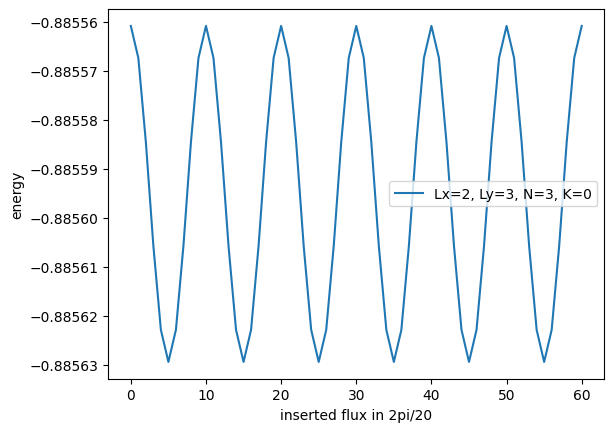

<class 'list'>
61
E[6pi flux]-E[0 flux]= -1.6109336087311021e-13


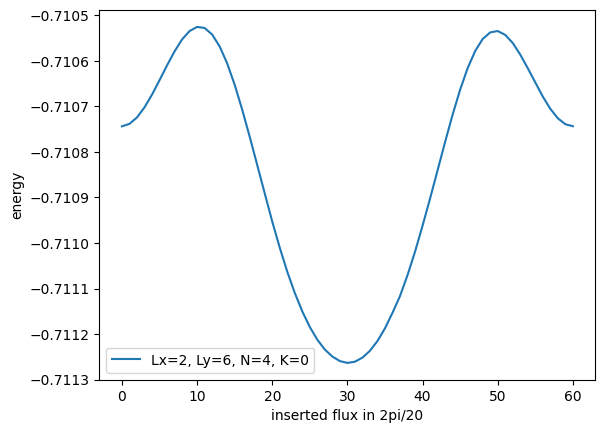

<class 'list'>
61
E[6pi flux]-E[0 flux]= 2.894318196222656e-07


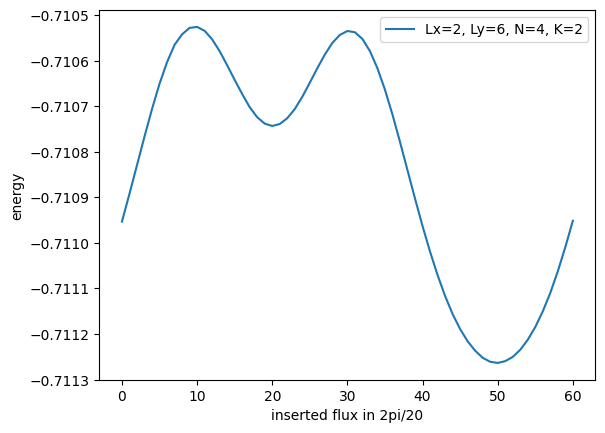

<class 'list'>
61
E[6pi flux]-E[0 flux]= 1.858030320933679e-06


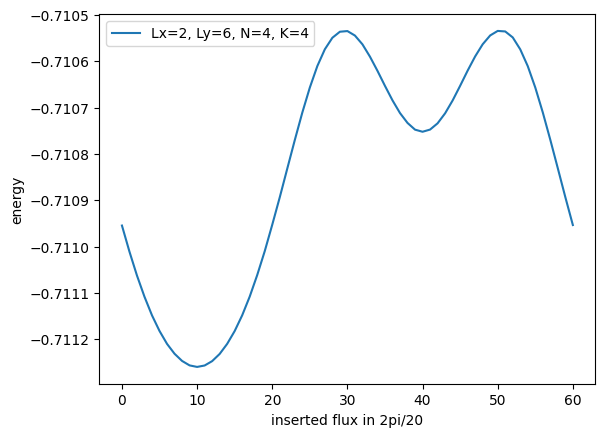

<class 'list'>
61
E[6pi flux]-E[0 flux]= 1.0868249471496227e-06


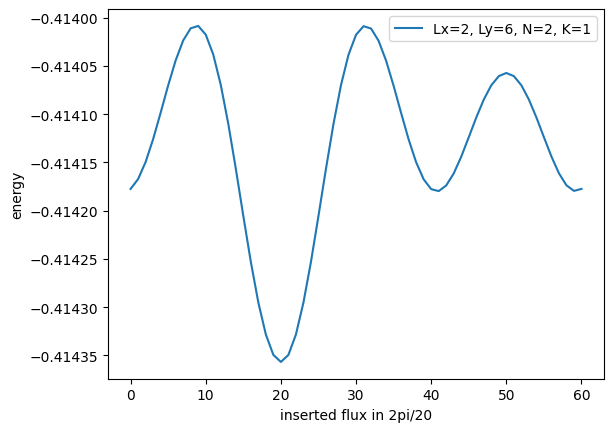

<class 'list'>
61
E[6pi flux]-E[0 flux]= 3.7532243368776363e-08


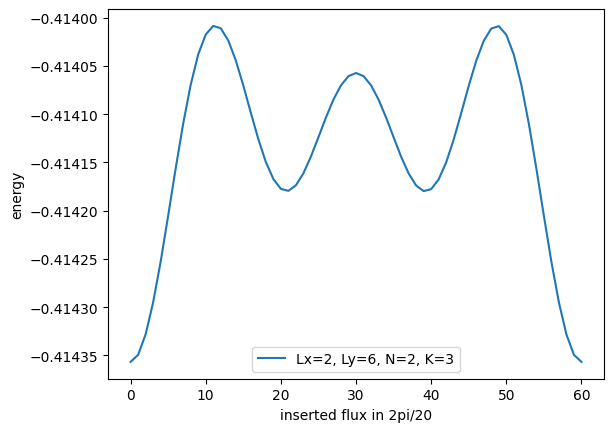

<class 'list'>
61
E[6pi flux]-E[0 flux]= 5.2202774269982655e-08


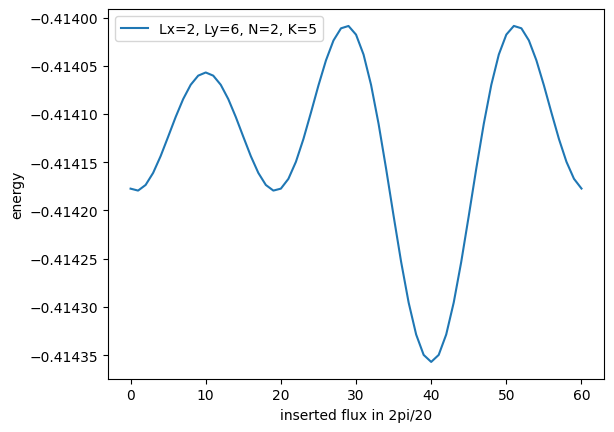

<class 'list'>
61
E[6pi flux]-E[0 flux]= 1.0207464384848208e-07


In [7]:
fname_1_K0_61 = ['entspec_xk_Hofst_BL_pi_2_chi256_Lx2_Ly3_t-1.0_tp-0.25_K0_N1fluxes0.0-3.00-61.h5', 'Lx=2, Ly=3, N=1, K=0']
fname_1_K1_61 = ['entspec_xk_Hofst_BL_pi_2_chi256_Lx2_Ly3_t-1.0_tp-0.25_K1_N1fluxes0.0-3.00-61.h5', 'Lx=2, Ly=3, N=1, K=1']
fname_1_K2_61 = ['entspec_xk_Hofst_BL_pi_2_chi256_Lx2_Ly3_t-1.0_tp-0.25_K2_N1fluxes0.0-3.00-61.h5', 'Lx=2, Ly=3, N=1, K=2']
fname_2_K0_61 = ['entspec_xk_Hofst_BL_pi_2_chi256_Lx2_Ly3_t-1.0_tp-0.25_K0_N2fluxes0.0-3.00-61.h5', 'Lx=2, Ly=3, N=2, K=0']
fname_2_K1_61 = ['entspec_xk_Hofst_BL_pi_2_chi256_Lx2_Ly3_t-1.0_tp-0.25_K1_N2fluxes0.0-3.00-61.h5', 'Lx=2, Ly=3, N=2, K=1']
fname_2_K2_61 = ['entspec_xk_Hofst_BL_pi_2_chi256_Lx2_Ly3_t-1.0_tp-0.25_K2_N2fluxes0.0-3.00-61.h5', 'Lx=2, Ly=3, N=2, K=2']
fname_3_K0_61 = ['entspec_xk_Hofst_BL_pi_2_chi256_Lx2_Ly3_t-1.0_tp-0.25_K0_N3fluxes0.0-3.00-61.h5', 'Lx=2, Ly=3, N=3, K=0']
fname_3_K1_61 = ['entspec_xk_Hofst_BL_pi_2_chi256_Lx2_Ly3_t-1.0_tp-0.25_K1_N3fluxes0.0-3.00-61.h5', 'Lx=2, Ly=3, N=3, K=1']
fname_3_K2_61 = ['entspec_xk_Hofst_BL_pi_2_chi256_Lx2_Ly3_t-1.0_tp-0.25_K2_N3fluxes0.0-3.00-61.h5', 'Lx=2, Ly=3, N=3, K=2']

fname_2_K1_61_ = ['entspec_xk_Hofst_BL_pi_2_chi512_Lx2_Ly6_t-1.0_tp-0.25_K1_N2fluxes0.0-3.00-61.h5', 'Lx=2, Ly=6, N=2, K=1']
fname_2_K3_61_ = ['entspec_xk_Hofst_BL_pi_2_chi512_Lx2_Ly6_t-1.0_tp-0.25_K3_N2fluxes0.0-3.00-61.h5', 'Lx=2, Ly=6, N=2, K=3']
fname_2_K5_61_ = ['entspec_xk_Hofst_BL_pi_2_chi512_Lx2_Ly6_t-1.0_tp-0.25_K5_N2fluxes0.0-3.00-61.h5', 'Lx=2, Ly=6, N=2, K=5']
fname_4_K0_61_ = ['entspec_xk_Hofst_BL_pi_2_chi512_Lx2_Ly6_t-1.0_tp-0.25_K0_N4fluxes0.0-3.00-61.h5', 'Lx=2, Ly=6, N=4, K=0']
fname_4_K2_61_ = ['entspec_xk_Hofst_BL_pi_2_chi512_Lx2_Ly6_t-1.0_tp-0.25_K2_N4fluxes0.0-3.00-61.h5', 'Lx=2, Ly=6, N=4, K=2']
fname_4_K4_61_ = ['entspec_xk_Hofst_BL_pi_2_chi512_Lx2_Ly6_t-1.0_tp-0.25_K4_N4fluxes0.0-3.00-61.h5', 'Lx=2, Ly=6, N=4, K=4']
fname_6_K0_61_ = ['entspec_xk_Hofst_BL_pi_2_chi512_Lx2_Ly6_t-1.0_tp-0.25_K0_N6fluxes0.0-3.00-61.h5', 'Lx=2, Ly=6, N=6, K=0']
fname_6_K2_61_ = ['entspec_xk_Hofst_BL_pi_2_chi512_Lx2_Ly6_t-1.0_tp-0.25_K2_N6fluxes0.0-3.00-61.h5', 'Lx=2, Ly=6, N=6, K=2']
fname_6_K4_61_ = ['entspec_xk_Hofst_BL_pi_2_chi512_Lx2_Ly6_t-1.0_tp-0.25_K4_N6fluxes0.0-3.00-61.h5', 'Lx=2, Ly=6, N=6, K=4']

fname_E_list = [fname_3_K0_61, fname_4_K0_61_, fname_4_K2_61_, fname_4_K4_61_, fname_2_K1_61_, fname_2_K3_61_, fname_2_K5_61_]

for fname in fname_E_list:
    data = load_data_h5(loc+fname[0])
    E = data['E']
    fig = pl.figure()
    ax.set_xlim(0, 9)
    pl.plot(E, label=fname[1])
    pl.ylabel('energy')
    pl.xlabel('inserted flux in 2pi/20')
    pl.legend()
    pl.show()
    print(type(E))
    print(len(E))
    print('E[6pi flux]-E[0 flux]=', E[len(E)-1]-E[0])

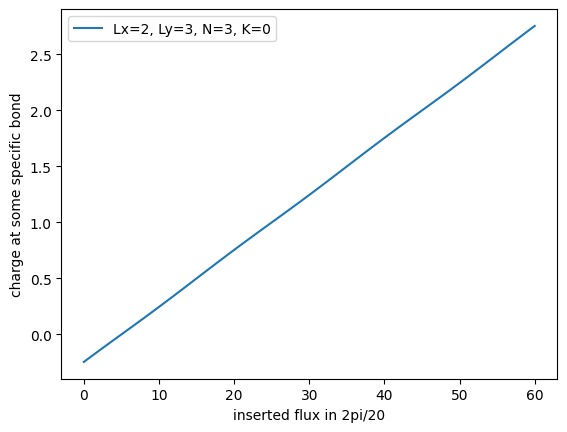

<class 'numpy.ndarray'>
61
Charge[6pi flux]-Charge[0 flux]= 3.000000000000539


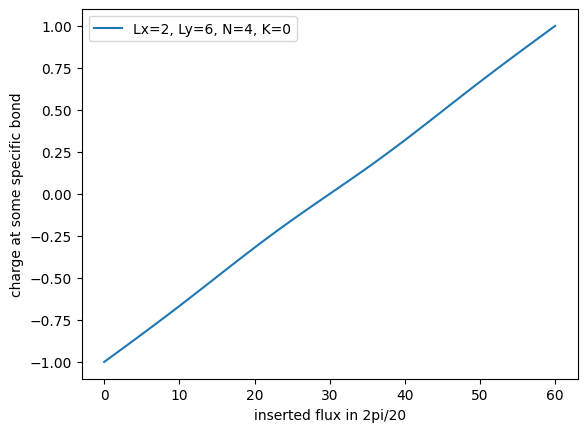

<class 'numpy.ndarray'>
61
Charge[6pi flux]-Charge[0 flux]= 1.9994539064302161


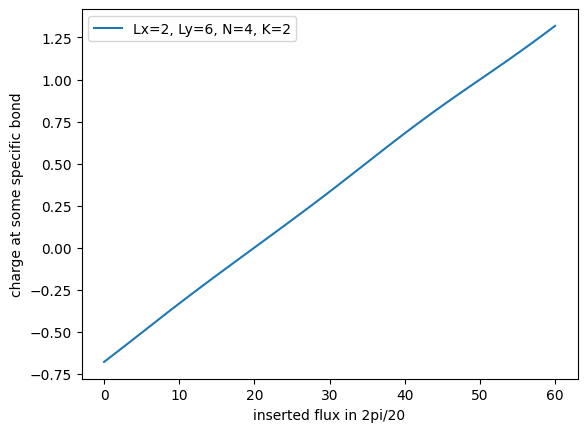

<class 'numpy.ndarray'>
61
Charge[6pi flux]-Charge[0 flux]= 1.9988022752685297


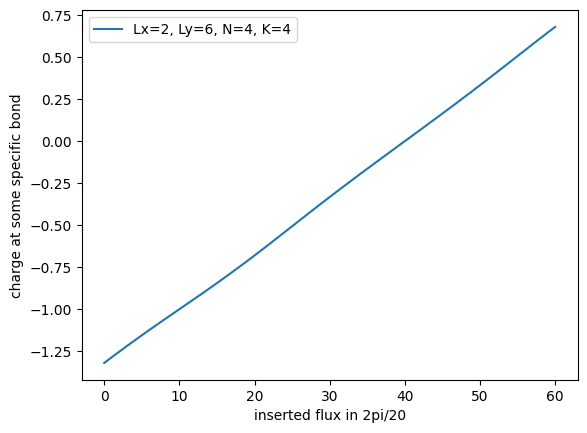

<class 'numpy.ndarray'>
61
Charge[6pi flux]-Charge[0 flux]= 1.9983402008942162


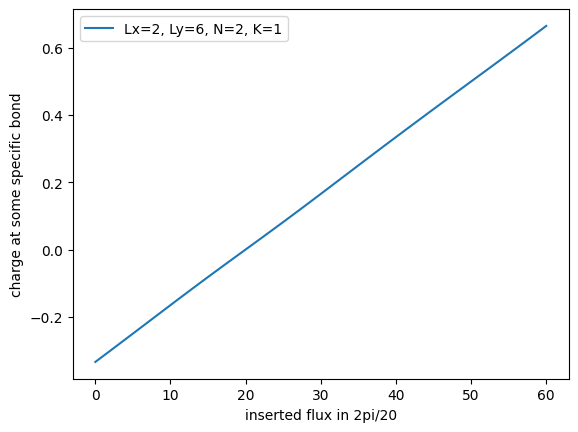

<class 'numpy.ndarray'>
61
Charge[6pi flux]-Charge[0 flux]= 0.9999523897508104


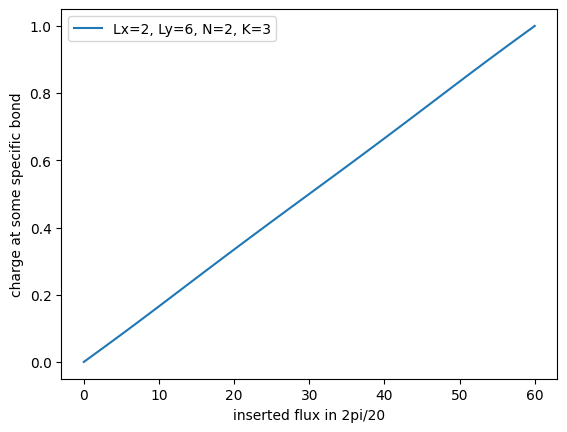

<class 'numpy.ndarray'>
61
Charge[6pi flux]-Charge[0 flux]= 0.9999777259201945


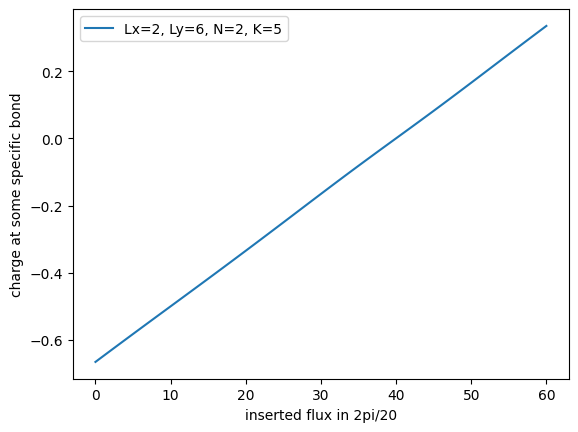

<class 'numpy.ndarray'>
61
Charge[6pi flux]-Charge[0 flux]= 0.9999392659304717


In [9]:

fname_QLs_list = [fname_3_K0_61, fname_4_K0_61_, fname_4_K2_61_, fname_4_K4_61_, fname_2_K1_61_, fname_2_K3_61_, fname_2_K5_61_]

for fname in fname_QLs_list:
    data = load_data_h5(loc+fname[0])
    QLs_ = data['QLs_']
    fig = pl.figure()
    ax.set_xlim(0, 9)
    pl.plot(QLs_, label=fname[1])
    pl.xlabel('inserted flux in 2pi/20')
    pl.ylabel('charge at some specific bond')
    pl.legend()
    pl.show()
    print(type(QLs_))
    print(len(QLs_))
    print('Charge[6pi flux]-Charge[0 flux]=', QLs_[len(QLs_)-1]-QLs_[0])